# Train a model using Watson Studio and deploy it in Watson Machine Learning

This notebook will show how to use your annotated images from Cloud Annotations to train an Object Detection model using a Python Notebook in Watson Studio. After training and testing, some extra steps will show how to deploy this model in Watson Machine Learning as an online API. You can use this API from any application afterwards.

As a suggestion you can use this dataset from Kaggle to test Cloud Annotation and this notebook: https://www.kaggle.com/issaisasank/guns-object-detection

### Specify the credentials for the bucket you used in Cloud Annoations

In [1]:
bucket = "<bucket-name>"
access_key_id = "<access_key_id>"
secret_access_key = "<secret_access_key>"
endpoint_url = "<endpoint_url>"

# Setup

In [2]:
import os
import shutil

if os.path.exists('tmp') and os.path.isdir('tmp'):
    shutil.rmtree('tmp')

CLOUD_ANNOTATIONS_DATA = os.path.join('tmp', bucket)

os.makedirs(CLOUD_ANNOTATIONS_DATA, exist_ok=True)

In [3]:
import json
import ibm_boto3

def download_file_cos(local_file_name, key): 
    '''
    Wrapper function to download a file from cloud object storage using the
    credential dict provided and loading it into memory
    '''
    cos = ibm_boto3.client(
        service_name='s3',
        aws_access_key_id=access_key_id,
        aws_secret_access_key=secret_access_key,
        endpoint_url=endpoint_url)
    try:
        res=cos.download_file(Bucket=bucket, Key=key, Filename=local_file_name)
    except Exception as e:
        print('Exception', e)
    else:
        print('File Downloaded')

def get_annotations(): 
    cos = ibm_boto3.client(
        service_name='s3',
        aws_access_key_id=access_key_id,
        aws_secret_access_key=secret_access_key,
        endpoint_url=endpoint_url)
    try:
        return json.loads(cos.get_object(Bucket=bucket, Key='_annotations.json')['Body'].read())
    except Exception as e:
        print('Exception', e)

In [4]:
annotations = get_annotations()

download_file_cos(os.path.join(CLOUD_ANNOTATIONS_DATA, '_annotations.json'), '_annotations.json')

for image in annotations['annotations'].keys():
    local_path = os.path.join(CLOUD_ANNOTATIONS_DATA, image)
    download_file_cos(local_path, image)

File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded


In [10]:
NUM_TRAIN_STEPS = 500
MODEL_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
CONFIG_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync'

import os
CLOUD_ANNOTATIONS_MOUNT = os.path.join('tmp', bucket)
ANNOTATIONS_JSON_PATH   = os.path.join(CLOUD_ANNOTATIONS_MOUNT, '_annotations.json')

CHECKPOINT_PATH = 'tmp/checkpoint'
OUTPUT_PATH     = 'tmp/output'
EXPORTED_PATH   = 'tmp/exported'
DATA_PATH       = 'tmp/data'

LABEL_MAP_PATH    = os.path.join(DATA_PATH, 'label_map.pbtxt')
TRAIN_RECORD_PATH = os.path.join(DATA_PATH, 'train.record')
VAL_RECORD_PATH   = os.path.join(DATA_PATH, 'val.record')

## Installing dependencies

In the next cell we will install the libraries that will be used. Since we are using an older version of Tensorflow and Numpy, compared to the version that is already installed by default in your environment. We highly suggest creating a custom environment in your Watson Studio project for this notebook, using the following configuration:

``````
# Modify the following content to add a software customization to an environment.
# To remove an existing customization, delete the entire content and click Apply.
# The customizations must follow the format of a conda environment yml file.

# Add conda channels below defaults, indented by two spaces and a hyphen.
channels:
  - defaults

# To add packages through conda or pip, remove the # on the following line.
dependencies:

# Add conda packages here, indented by two spaces and a hyphen.
# Remove the # on the following line and replace sample package name with your package name:

# Add pip packages here, indented by four spaces and a hyphen.
# Remove the # on the following lines and replace sample package name with your package name.
  - pip:
    - numpy==1.19.5
    - tensorflow==1.15.2
``````

Use Python 3.7 and any hardware configuration without CPU that you would like. This notebook was not prepared to support training using GPUs in Watson Studio. Use the next cell to install the other dependencies as normal. After creating the environment you will have to change it using the **Information** tab, on the right side menu.

In [6]:
import os
import sys
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/cloud-annotations/models

# !pip uninstall Cython -y
# !pip uninstall tf_slim -y
# !pip uninstall opencv-python-headless -y
# !pip uninstall lvis -y
# !pip uninstall pycocotools -y
# !pip uninstall numpy -y
# !pip uninstall tensorflow -y    

# !pip install numpy==1.19.5
# !pip install tensorflow==1.15.2
!pip install Cython
!pip install tf_slim
!pip install opencv-python-headless
!pip install lvis --no-deps
!pip install pycocotools

%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

pwd = os.getcwd()
# we need to set both PYTHONPATH for shell scripts and sys.path for python cells
sys.path.append(pwd)
sys.path.append(os.path.join(pwd, 'slim'))
if 'PYTHONPATH' in os.environ:
    os.environ['PYTHONPATH'] += f':{pwd}:{pwd}/slim'
else:
    os.environ['PYTHONPATH'] = f':{pwd}:{pwd}/slim'
%cd ../..

Cloning into 'models'...
remote: Enumerating objects: 2282, done.
remote: Counting objects: 100% (2282/2282), done.
remote: Compressing objects: 100% (1930/1930), done.
remote: Total 2282 (delta 523), reused 1238 (delta 326), pack-reused 0
Receiving objects: 100% (2282/2282), 30.58 MiB | 44.86 MiB/s, done.
Resolving deltas: 100% (523/523), done.
     |████████████████████████████████| 2.0 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 352 kB 20.4 MB/s eta 0:00:01
     |████████████████████████████████| 37.6 MB 12.9 MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=326775 sha256=984c3d2c339d5f21cfb53ff88d7123353e89b187ccf402cbb85d058b361a8747
  Stored in directory: /home/wsuser/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools
/home/wsuser/work/models/research
/home/wsuser/work


## Testing Tensorflow

In [7]:
%cd models/research
!python object_detection/builders/model_builder_tf1_test.py
%cd ../..

/home/wsuser/work/models/research
Running tests under Python 3.7.10: /opt/conda/envs/Python-3.7-main/bin/python
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params(True)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params(True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params(False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params(False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from

# Generate a Label Map

One piece of data the Object Detection API needs is a label map protobuf. The label map associates an integer id to the text representation of the label. The ids are indexed by 1, meaning the first label will have an id of 1 not 0.

Here is an example of what a label map looks like:

````
item {
  id: 1
  name: 'Cat'
}

item {
  id: 2
  name: 'Dog'
}

item {
  id: 3
  name: 'Gold Fish'
}
````


In [11]:
import os
import json

# Get a list of labels from the annotations.json
labels = {}
with open(ANNOTATIONS_JSON_PATH) as f:
    annotations = json.load(f)
    labels = annotations['labels']

# Create a file named label_map.pbtxt
os.makedirs(DATA_PATH, exist_ok=True)
with open(LABEL_MAP_PATH, 'w') as f:
  # Loop through all of the labels and write each label to the file with an id
  for idx, label in enumerate(labels):
    f.write('item {\n')
    f.write("\tname: '{}'\n".format(label))
    f.write('\tid: {}\n'.format(idx + 1)) # indexes must start at 1
    f.write('}\n')

# Generate TFRecords

The TensorFlow Object Detection API expects our data to be in the format of TFRecords.

The TFRecord format is a collection of serialized feature dicts, one for each image, looking something like this:

````
{
  'image/height': 1800,
  'image/width': 2400,
  'image/filename': 'image1.jpg',
  'image/source_id': 'image1.jpg',
  'image/encoded': ACTUAL_ENCODED_IMAGE_DATA_AS_BYTES,
  'image/format': 'jpeg',
  'image/object/bbox/xmin': [0.7255949630314233, 0.8845598428835489],
  'image/object/bbox/xmax': [0.9695875693160814, 1.0000000000000000],
  'image/object/bbox/ymin': [0.5820120073891626, 0.1829972290640394],
  'image/object/bbox/ymax': [1.0000000000000000, 0.9662484605911330],
  'image/object/class/text': (['Cat', 'Dog']),
  'image/object/class/label': ([1, 2])
}
````


In [12]:
import os
import io
import json
import random

import PIL.Image
import tensorflow as tf

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

def create_tf_record(images, annotations, label_map, image_path, output):
  # Create a train.record TFRecord file.
  with tf.python_io.TFRecordWriter(output) as writer:
    # Loop through all the training examples.
    for image_name in images:
        try:
            # Make sure the image is actually a file
            img_path = os.path.join(image_path, image_name)   
            if not os.path.isfile(img_path):
                  continue

            # Read in the image.
            with tf.gfile.GFile(img_path, 'rb') as fid:
                  encoded_jpg = fid.read()

            # Open the image with PIL so we can check that it's a jpeg and get the image
            # dimensions.
            encoded_jpg_io = io.BytesIO(encoded_jpg)
            image = PIL.Image.open(encoded_jpg_io)
            if image.format != 'JPEG':
                  raise ValueError('Image format not JPEG')

            width, height = image.size

            # Initialize all the arrays.
            xmins = []
            xmaxs = []
            ymins = []
            ymaxs = []
            classes_text = []
            classes = []

            # The class text is the label name and the class is the id. If there are 3
            # cats in the image and 1 dog, it may look something like this:
            # classes_text = ['Cat', 'Cat', 'Dog', 'Cat']
            # classes      = [  1  ,   1  ,   2  ,   1  ]

            # For each image, loop through all the annotations and append their values.
            for a in annotations[image_name]:
                if ("x" in a and "x2" in a and "y" in a and "y2" in a):
                    label = a['label']
                    xmins.append(a["x"])
                    xmaxs.append(a["x2"])
                    ymins.append(a["y"])
                    ymaxs.append(a["y2"])
                    classes_text.append(label.encode("utf8"))
                    classes.append(label_map[label])

            # Create the TFExample.
            tf_example = tf.train.Example(features=tf.train.Features(feature={
              'image/height': dataset_util.int64_feature(height),
              'image/width': dataset_util.int64_feature(width),
              'image/filename': dataset_util.bytes_feature(image_name.encode('utf8')),
              'image/source_id': dataset_util.bytes_feature(image_name.encode('utf8')),
              'image/encoded': dataset_util.bytes_feature(encoded_jpg),
              'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
              'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
              'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
              'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
              'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
              'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
              'image/object/class/label': dataset_util.int64_list_feature(classes),
            }))
            if tf_example:
                # Write the TFExample to the TFRecord.
                writer.write(tf_example.SerializeToString())
        except ValueError:
            print('Invalid example, ignoring.')
            pass
        except IOError:
            print("Can't read example, ignoring.")
            pass

with open(ANNOTATIONS_JSON_PATH) as f:
    annotations = json.load(f)['annotations']
    image_files = [image for image in annotations.keys()]
    # Load the label map we created.
    label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)

    random.seed(42)
    random.shuffle(image_files)
    num_train = int(0.7 * len(image_files))
    train_examples = image_files[:num_train]
    val_examples = image_files[num_train:]

    create_tf_record(train_examples, annotations, label_map, CLOUD_ANNOTATIONS_MOUNT, TRAIN_RECORD_PATH)
    create_tf_record(val_examples, annotations, label_map, CLOUD_ANNOTATIONS_MOUNT, VAL_RECORD_PATH)

# Download a base model

Training a model from scratch can take days and tons of data. We can mitigate this by using a pretrained model checkpoint. Instead of starting from nothing, we can add to what was already learned with our own data.

There are several pretrained model checkpoints that can be downloaded from the model zoo.

The model we will be training is the SSD MobileNet architecture. SSD MobileNet models have a very small file size and can execute very quickly, compromising little accuracy, which makes it perfect for running in the browser. Additionally, we will be using quantization. When we say the model is quantized it means instead of using float32 as the datatype of our numbers we are using float16 or int8.

````
float32(PI) = 3.1415927 32 bits
float16(PI) = 3.14 16 bits
int8(PI) = 3 8 bits
````

We do this because it can cut our model size down by around a factor of 4! An unquantized version of SSD MobileNet that I trained was 22.3 MB, but the quantized version was 5.7 MB that's a ~75% reduction 🎉

In [13]:
import os
import tarfile

import six.moves.urllib as urllib

download_base = 'http://download.tensorflow.org/models/object_detection/'
model = MODEL_TYPE + '.tar.gz'
tmp = 'tmp/checkpoint.tar.gz'

if not (os.path.exists(CHECKPOINT_PATH)):
    # Download the checkpoint
    opener = urllib.request.URLopener()
    opener.retrieve(download_base + model, tmp)

    # Extract all the `model.ckpt` files.
    with tarfile.open(tmp) as tar:
        for member in tar.getmembers():
            member.name = os.path.basename(member.name)
            if 'model.ckpt' in member.name:
                tar.extract(member, path=CHECKPOINT_PATH)

    os.remove(tmp)

# Model Config

The final thing we need to do is inject our pipline with the amount of labels we have and where to find the label map, TFRecord and model checkpoint. We also need to change the the batch size, because the default batch size of 128 is too large for Colab to handle.

In [14]:

#from google.protobuf import text_format

from object_detection.utils import config_util
from object_detection.utils import label_map_util

pipeline_skeleton = 'models/research/object_detection/samples/configs/' + CONFIG_TYPE + '.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_skeleton)

label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)
num_classes = len(label_map.keys())
meta_arch = configs["model"].WhichOneof("model")

override_dict = {
  'model.{}.num_classes'.format(meta_arch): num_classes,
  'train_config.batch_size': 24,
  'train_input_path': TRAIN_RECORD_PATH,
  'eval_input_path': VAL_RECORD_PATH,
  'train_config.fine_tune_checkpoint': os.path.join(CHECKPOINT_PATH, 'model.ckpt'),
  'label_map_path': LABEL_MAP_PATH
}

configs = config_util.merge_external_params_with_configs(configs, kwargs_dict=override_dict)
pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_config, DATA_PATH)

INFO:tensorflow:Maybe overwriting model.ssd.num_classes: 3
INFO:tensorflow:Maybe overwriting train_config.batch_size: 24
INFO:tensorflow:Maybe overwriting train_input_path: tmp/data/train.record
INFO:tensorflow:Maybe overwriting eval_input_path: tmp/data/val.record
INFO:tensorflow:Maybe overwriting train_config.fine_tune_checkpoint: tmp/checkpoint/model.ckpt
INFO:tensorflow:Maybe overwriting label_map_path: tmp/data/label_map.pbtxt
INFO:tensorflow:Writing pipeline config file to tmp/data/pipeline.config


# Start training

We can start a training run by calling the model_main script, passing:

- The location of the pipepline.config we created
- Where we want to save the model
- How many steps we want to train the model (the longer you train, the more potential there is to learn)
- The number of evaluation steps (or how often to test the model) gives us an idea of how well the model is doing

In [15]:
!rm -rf $OUTPUT_PATH
!python -m object_detection.model_main \
    --pipeline_config_path=$DATA_PATH/pipeline.config \
    --model_dir=$OUTPUT_PATH \
    --num_train_steps=$NUM_TRAIN_STEPS \
    --num_eval_steps=100

W0309 22:13:22.687586 140547391756096 model_lib.py:801] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 500
I0309 22:13:22.687775 140547391756096 config_util.py:552] Maybe overwriting train_steps: 500
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0309 22:13:22.687845 140547391756096 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0309 22:13:22.687905 140547391756096 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0309 22:13:22.687964 140547391756096 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0309 22:13:22.688039 140547391756096 model_lib.py:817] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_tpu

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0309 22:13:33.128999 140547391756096 deprecation.py:323] From /home/wsuser/work/models/research/object_detection/inputs.py:77: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W0309 22:13:39.146054 140547391756096 api.py:332] From /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:1004: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use `tf.cast` instead.
W0309 

INFO:tensorflow:Done calling model_fn.
I0309 22:13:58.793164 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
I0309 22:13:58.794261 140547391756096 basic_session_run_hooks.py:541] Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
I0309 22:14:01.628111 140547391756096 monitored_session.py:240] Graph was finalized.
2021-03-09 22:14:01.628484: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-09 22:14:01.637763: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294705000 Hz
2021-03-09 22:14:01.642136: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559c49a6e8c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-09 22:14:01.642169: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
INFO:t

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0309 22:24:30.443849 140547391756096 deprecation.py:323] From /home/wsuser/work/models/research/object_detection/utils/visualization_utils.py:618: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there

INFO:tensorflow:depth of additional conv before box predictor: 0
I0309 22:34:33.853404 140547391756096 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/add_fold
I0309 22:34:35.638255 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_0/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_1_depthwise/add_fold
I0309 22:34:35.638581 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_1_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_1_pointwise/add_fold
I0309 22:34:35.638734 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_1_pointwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/C

INFO:tensorflow:Done calling model_fn.
I0309 22:34:36.275506 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T22:34:36Z
I0309 22:34:36.291119 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T22:34:36Z
INFO:tensorflow:Graph was finalized.
I0309 22:34:36.673747 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-125
I0309 22:34:36.676204 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-125
INFO:tensorflow:Running local_init_op.
I0309 22:34:37.732309 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 22:34:37.908616 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 22:34:41.944044 140527529862912 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Done calling model_fn.
I0309 22:44:40.616745 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T22:44:40Z
I0309 22:44:40.631649 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T22:44:40Z
INFO:tensorflow:Graph was finalized.
I0309 22:44:41.415257 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-185
I0309 22:44:41.416983 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-185
INFO:tensorflow:Running local_init_op.
I0309 22:44:42.462133 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 22:44:42.628157 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 22:44:46.541659 140527387252480 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/add_fold
I0309 22:54:44.909239 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_4_pointwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/add_fold
I0309 22:54:44.909394 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_pointwise/add_fold
I0309 22:54:44.909533 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_5_pointwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_6_depthwise/add_fold
I0309 22:54:44.909713 140547391756096 quantize.py:299] Skipping quant after FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_6_depthwise/add_f

DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

INFO:tensorflow:Done calling model_fn.
I0309 23:04:52.507979 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T23:04:52Z
I0309 23:04:52.524100 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T23:04:52Z
INFO:tensorflow:Graph was finalized.
I0309 23:04:52.909255 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-312
I0309 23:04:52.911524 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-312
INFO:tensorflow:Running local_init_op.
I0309 23:04:53.962214 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 23:04:54.126037 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 23:04:58.063615 140528226129664 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Done calling model_fn.
I0309 23:15:00.706901 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T23:15:00Z
I0309 23:15:00.722930 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T23:15:00Z
INFO:tensorflow:Graph was finalized.
I0309 23:15:01.133093 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-375
I0309 23:15:01.134781 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-375
INFO:tensorflow:Running local_init_op.
I0309 23:15:02.159041 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 23:15:02.311786 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 23:15:06.234744 140529224369920 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Done calling model_fn.
I0309 23:25:03.545919 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T23:25:03Z
I0309 23:25:03.561532 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T23:25:03Z
INFO:tensorflow:Graph was finalized.
I0309 23:25:03.940626 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-435
I0309 23:25:03.942279 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-435
INFO:tensorflow:Running local_init_op.
I0309 23:25:04.992221 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 23:25:05.161858 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 23:25:09.197746 140527404037888 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Done calling model_fn.
I0309 23:35:06.668152 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T23:35:06Z
I0309 23:35:06.682952 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T23:35:06Z
INFO:tensorflow:Graph was finalized.
I0309 23:35:07.063272 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-496
I0309 23:35:07.064889 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-496
INFO:tensorflow:Running local_init_op.
I0309 23:35:08.127432 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 23:35:08.291833 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 23:35:11.979288 140527420823296 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:Done calling model_fn.
I0309 23:35:49.500890 140547391756096 estimator.py:1150] Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-09T23:35:49Z
I0309 23:35:49.516814 140547391756096 evaluation.py:255] Starting evaluation at 2021-03-09T23:35:49Z
INFO:tensorflow:Graph was finalized.
I0309 23:35:49.901134 140547391756096 monitored_session.py:240] Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-500
I0309 23:35:49.902749 140547391756096 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-500
INFO:tensorflow:Running local_init_op.
I0309 23:35:50.967039 140547391756096 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I0309 23:35:51.120415 140547391756096 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Performing evaluation on 17 images.
I0309 23:35:54.757559 140527387252480 coco_evaluation.py:282] Performing evaluation on 17 images.
creating index...

INFO:tensorflow:SavedModel written to: tmp/output/export/Servo/temp-b'1615332954'/saved_model.pb
I0309 23:35:58.172749 140547391756096 builder_impl.py:425] SavedModel written to: tmp/output/export/Servo/temp-b'1615332954'/saved_model.pb
INFO:tensorflow:Loss for final step: 0.8415153.
I0309 23:35:58.487592 140547391756096 estimator.py:371] Loss for final step: 0.8415153.


# Export inference graph

After your model has been trained, you might have a few checkpoints available. A checkpoint is usually emitted every 500 training steps. Each checkpoint is a snapshot of your model at that point in training. In the event that a long running training process crashes, you can pick up at the last checkpoint instead of starting from scratch.

We need to export a checkpoint to a TensorFlow graph proto in order to actually use it. We use regex to find the checkpoint with the highest training step and export it.

In [16]:
import os
import re
import json

from object_detection.utils.label_map_util import get_label_map_dict

regex = re.compile(r"model\.ckpt-([0-9]+)\.index")
numbers = [int(regex.search(f).group(1)) for f in os.listdir(OUTPUT_PATH) if regex.search(f)]
TRAINED_CHECKPOINT_PREFIX = os.path.join(OUTPUT_PATH, 'model.ckpt-{}'.format(max(numbers)))

print(f'Using {TRAINED_CHECKPOINT_PREFIX}')

!rm -rf $EXPORTED_PATH
!python -m object_detection.export_inference_graph \
    --pipeline_config_path=$DATA_PATH/pipeline.config \
    --trained_checkpoint_prefix=$TRAINED_CHECKPOINT_PREFIX \
    --output_directory=$EXPORTED_PATH

label_map = get_label_map_dict(LABEL_MAP_PATH)
label_array = [k for k in sorted(label_map, key=label_map.get)]

with open(os.path.join(EXPORTED_PATH, 'labels.json'), 'w') as f:
    json.dump(label_array, f)

Using tmp/output/model.ckpt-100
Instructions for updating:
Please use `layer.__call__` method instead.
W0309 21:33:06.507993 140482521331520 deprecation.py:323] From /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0309 21:33:08.041270 140482521331520 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0309 21:33:08.085077 140482521331520 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0309 21:33:08.126029 140482521331520 convolutional_box_predictor.py:156] depth of additional conv before box predi

182 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================
Incomplete shape.

Doc:
scope: The nodes in the model graph are organized by their names, which is hierar

182 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*,.*Initializer.*,.*Regularizer.*,.*BiasAdd.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================
Incomplete shape.

Doc:
scope: The nodes in the model graph are organiz

2021-03-09 21:33:12.218444: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-09 21:33:12.231389: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600090000 Hz
2021-03-09 21:33:12.237922: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559b1af56540 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-09 21:33:12.237963: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
INFO:tensorflow:Restoring parameters from tmp/output/model.ckpt-100
I0309 21:33:12.245402 140482521331520 saver.py:1284] Restoring parameters from tmp/output/model.ckpt-100
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0309 21:33:13.698019 140482521331520 deprecation.py:323] From /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/tensor

# Evaluating the results

In the next steps we will use the images from the evaluation set to **visualize** the results of our model. If you don't see any boxes in your images, consider raising the amount of training steps in the **SETUP** section or adding more training images.

In [33]:

import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as PImage
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

# Load the labels
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

# Load the model
path_to_frozen_graph = os.path.join(EXPORTED_PATH, 'frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [44]:
bbox_images = []
for image_x in val_examples:
    img_path = os.path.join(CLOUD_ANNOTATIONS_MOUNT, image_x)   
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            image = PImage.open(img_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            (im_width, im_height) = image.size
            image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
            
            bbox_images.append(image_np)

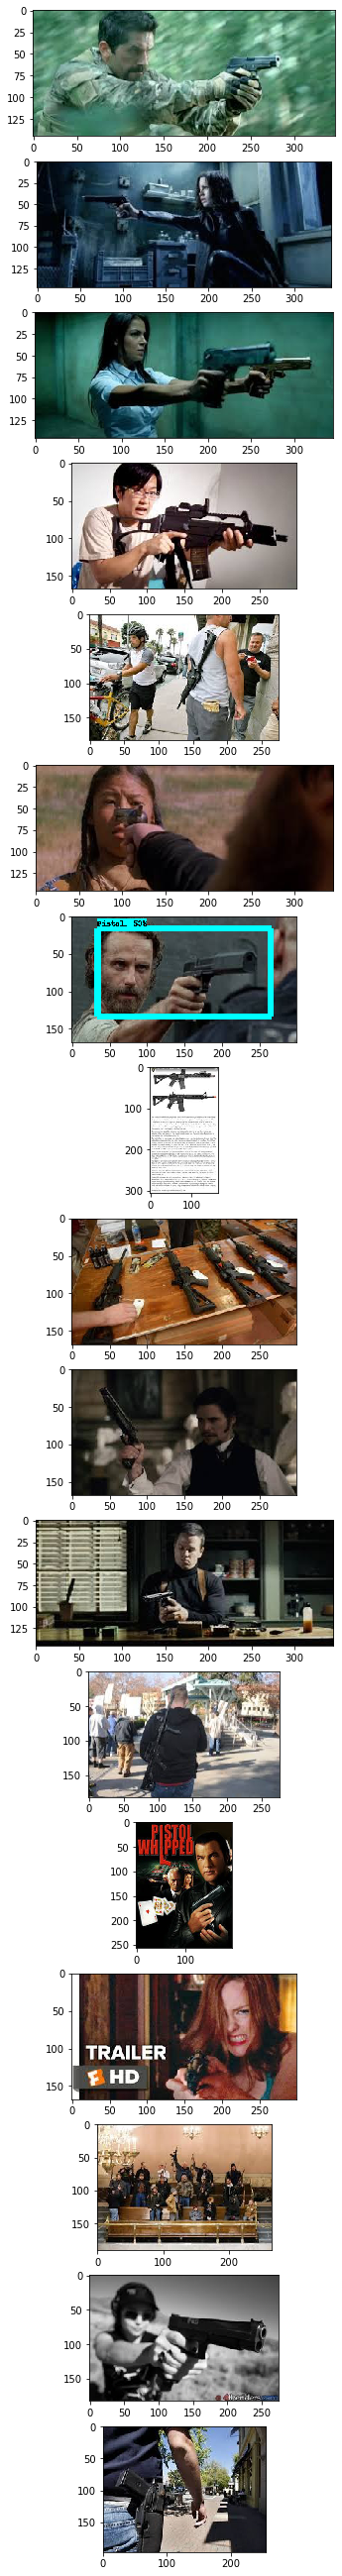

In [46]:
%matplotlib inline

fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i,bbox_image in enumerate(bbox_images):
    sub = fig.add_subplot(len(bbox_images)+1, 1, i + 1)
    sub.imshow(bbox_image, interpolation='nearest')

### Here you can choose different images from the array to see it in more detail

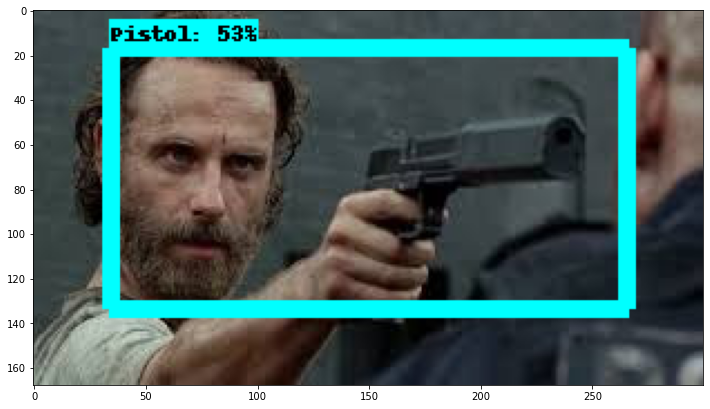

In [49]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.imshow(bbox_images[6])

# Deploying your model in Watson Machine Leaning

In the following steps we will export the artifacts that were created to a .tar file and upload the model to Watson Machine Learning. Than we will generate an online deployment using this model.

You will need a Watson Machine Leaning instance and an IAM API Key in IBM Cloud that has access to this instance. See the steps in the documentation:

https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html

Also, in the new version of WML you will need a Deployment Space and it's ID

https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-spaces_local.html?audience=wdp

In [71]:
!ls $EXPORTED_PATH/saved_model

saved_model.pb	variables


In [72]:
!tar -zcvf guns-object-detection-model.tar.gz -C $EXPORTED_PATH/saved_model .

./
./saved_model.pb
./variables/


In [1]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"<apikey>"
                  }

client = APIClient(wml_credentials)

In [2]:
client.set.default_space("<deployment-space-id>")

'SUCCESS'

In [ ]:
client.software_specifications.list()

In [76]:
model_spec = client.software_specifications.get_id_by_name('tensorflow_1.15-py3.6')

In [77]:
model_meta = {
    client.repository.ModelMetaNames.NAME              : "Tensorflow Guns Object Detection Model",
    client.repository.ModelMetaNames.DESCRIPTION       : "Guns Object Detection using Kaggle Dataset",
    client.repository.ModelMetaNames.TYPE              : "tensorflow_1.15",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID : model_spec
}
model_details_dir = client.repository.store_model( model="guns-object-detection-model.tar.gz", meta_props=model_meta )

Note: Warnings!! :  Model type tensorflow_1.15 is deprecated. We recommend you use a supported model type. See Supported Frameworks https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html.


In [78]:
model_id_dir = model_details_dir["metadata"]['id']

In [ ]:
client.hardware_specifications.list()

In [ ]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "Tensorflow Guns Object Detection Deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC : { "id":  "cf70f086-916d-4684-91a7-264c49c6d425"}
}
deployment_details_dir = client.deployments.create(model_id_dir, meta_props )

In [3]:
deployment_id = deployment_details_dir['metadata']['id']

# Test the deployed model

Choose one of the images from the evaluation set to score the model using the newly created API. This step can be done in another notebook or custom code, since your deployed model is not dependent of this kernel. 

In [35]:
img_path = os.path.join(CLOUD_ANNOTATIONS_MOUNT, val_examples[5])   
if os.path.isfile(img_path):
    print("OK")

OK


In [89]:
image = PImage.open(img_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [90]:
data = image_np.tolist()
payload_scoring = {
  "input_data": [{
    "values": [data]
  }]
}

In [91]:
%%time
predictions = client.deployments.score(deployment_id, payload_scoring)

CPU times: user 86.7 ms, sys: 7.72 ms, total: 94.4 ms
Wall time: 827 ms


In [92]:
for x in predictions['predictions']:
    if x['id'] == 'detection_scores':
        scores = x['values'][0]
    if x['id'] == 'detection_boxes':
        boxes = x['values'][0]
    if x['id'] == 'num_detections':
        num = x['values'][0]
    if x['id'] == 'detection_classes':
        classes = x['values'][0]

In [93]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=8)

array([[[247, 245, 250],
        [231, 229, 234],
        [244, 242, 245],
        ...,
        [226, 226, 226],
        [208, 208, 208],
        [254, 254, 254]],

       [[255, 254, 255],
        [ 29,  27,  28],
        [ 39,  37,  38],
        ...,
        [ 58,  58,  58],
        [ 38,  38,  38],
        [230, 230, 230]],

       [[241, 240, 238],
        [ 68,  67,  63],
        [ 87,  86,  82],
        ...,
        [ 98,  98,  98],
        [ 44,  44,  44],
        [246, 246, 246]],

       ...,

       [[243, 243, 243],
        [251, 251, 251],
        [251, 251, 251],
        ...,
        [255, 255, 255],
        [253, 253, 253],
        [252, 252, 252]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [249, 249, 249],
        [248, 248, 248],
        [248, 248, 248]],

       [[248, 248, 248],
        [248, 248, 248],
        [248, 248, 248],
        ...,
        [249, 249, 249],
        [248, 248, 248],
        [248, 248, 248]]

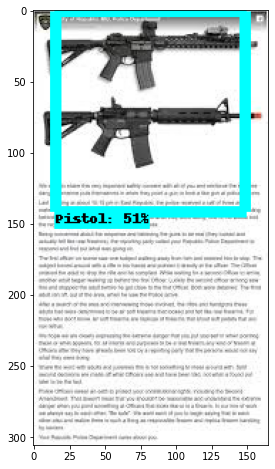

In [95]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.imshow(image_np)